In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

path = "drive/My Drive/Colab Notebooks/DSN 2019"
os.chdir(path)
!ls

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns                  # For data visualization 
import matplotlib.pyplot as plt        # For plotting graphs 
%matplotlib inline 
import warnings                        # To ignore any warnings warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn import ensemble
from sklearn.ensemble import *
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, classification_report, roc_auc_score
from collections import Counter
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, HistGradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold
# from catboost import Pool, CatBoostClassifier, cv

# Load Data

In [0]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
train.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [0]:
train['sep']='train'
test['sep']='test'
data = pd.concat([train,test], sort=False)
data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim,sep
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0.0,train
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0.0,train
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0.0,train
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0.0,train
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0.0,train


In [0]:
data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim,sep
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0.0,train
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0.0,train
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0.0,train
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0.0,train
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0.0,train


# Bi-variate Analysis

## Independent Variable (Categorical)

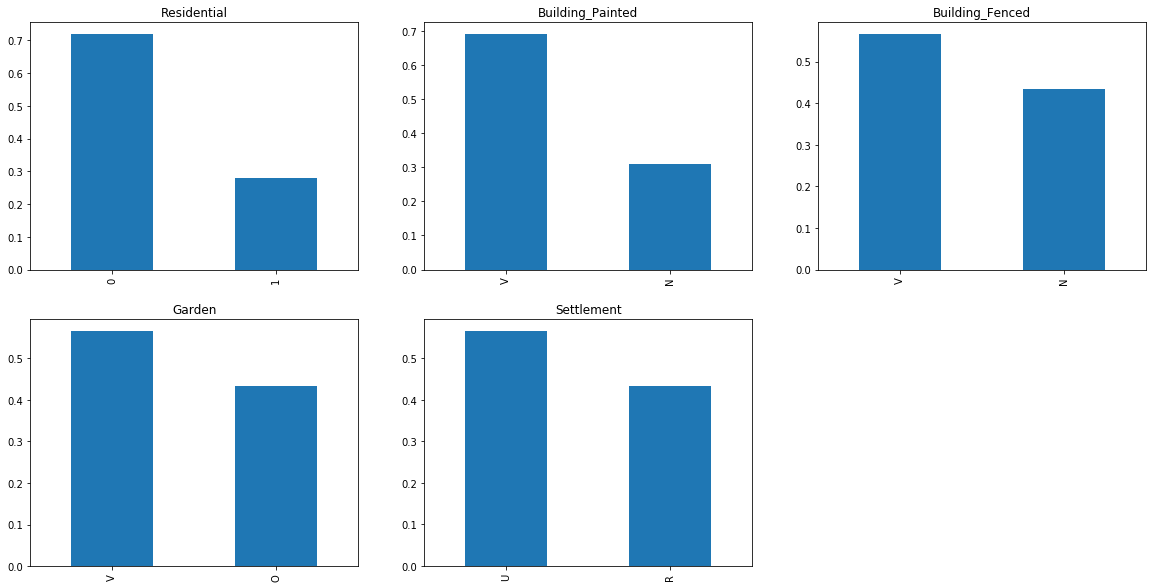

In [0]:
plt.figure(1) 
plt.subplot(231) 
data['Residential'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'Residential') 
plt.subplot(232) 
data['Building_Painted'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'Building_Painted')
plt.subplot(233) 
data['Building_Fenced'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'Building_Fenced')
plt.subplot(234) 
data['Garden'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'Garden')
plt.subplot(235) 
data['Settlement'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'Settlement')
plt.show()

## Independent Variable (Ordinal)

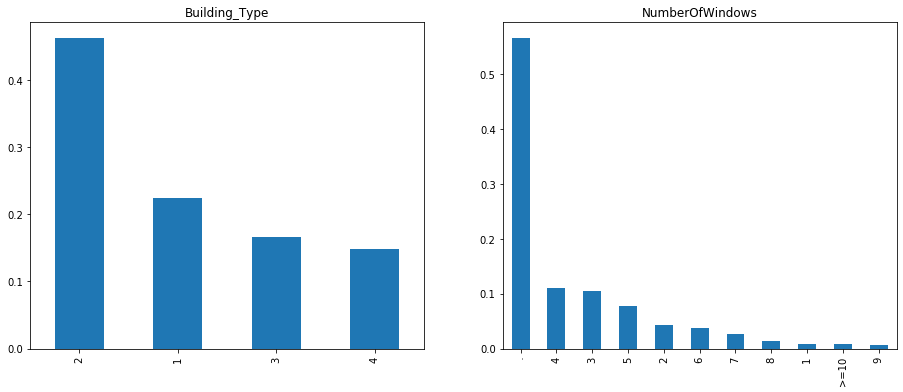

In [0]:
plt.figure(1) 
plt.subplot(131) 
data['Building_Type'].value_counts(normalize=True).plot.bar(figsize=(24,6), title= 'Building_Type') 
plt.subplot(132) 
data['NumberOfWindows'].value_counts(normalize=True).plot.bar(figsize=(24,6), title= 'NumberOfWindows') 

## Independent Variable (Numerical)

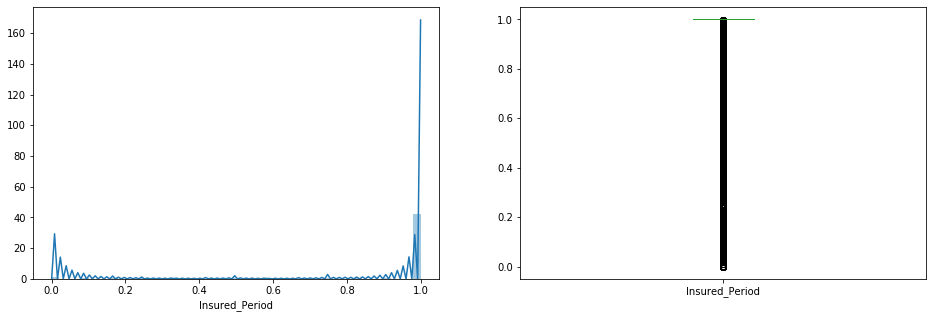

In [0]:
plt.figure(1) 
plt.subplot(121) 
sns.distplot(data['Insured_Period']); 
plt.subplot(122) 
data['Insured_Period'].plot.box(figsize=(16,5)) 
plt.show()

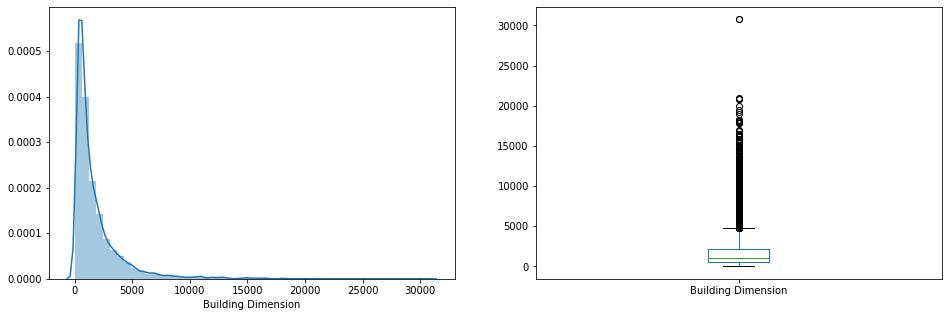

In [0]:
plt.figure(1) 
plt.subplot(121) 
sns.distplot(data[data['Building Dimension'].notnull()]['Building Dimension']); 
plt.subplot(122) 
data[data['Building Dimension'].notnull()]['Building Dimension'].plot.box(figsize=(16,5)) 
plt.show()

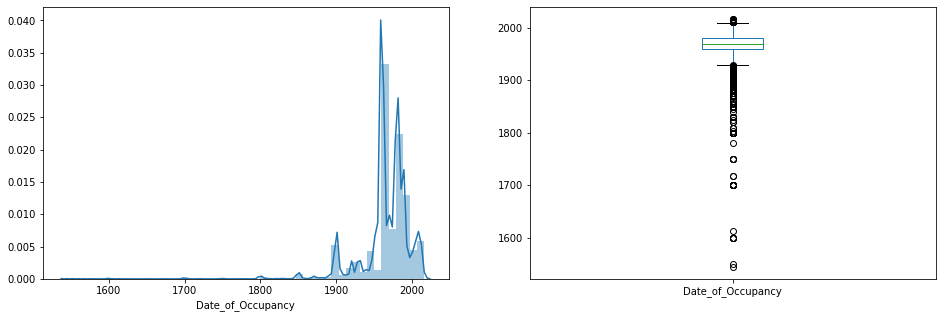

In [0]:
plt.figure(1) 
plt.subplot(121) 
sns.distplot(data[data['Date_of_Occupancy'].notnull()]['Date_of_Occupancy']); 
plt.subplot(122) 
data[data['Date_of_Occupancy'].notnull()]['Date_of_Occupancy'].plot.box(figsize=(16,5)) 
plt.show()

# Bivariate Analysis

## Categorical Independent Variable vs Target Variable

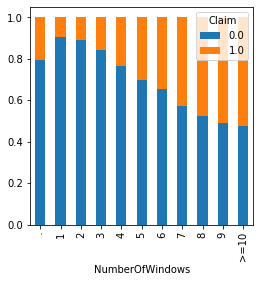

In [0]:
NumberOfWindows=pd.crosstab(data['NumberOfWindows'],data['Claim']) 
NumberOfWindows.div(NumberOfWindows.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(4,4))

## Numerical Independent Variable vs Target Variable

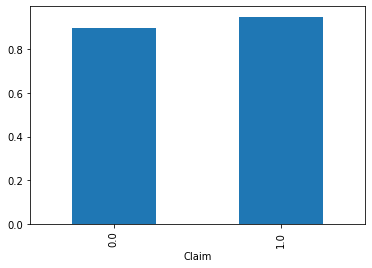

In [0]:
data.groupby('Claim')['Insured_Period'].mean().plot.bar()

# Handling Missing Values

In [0]:
data.isnull().sum()

Customer Id              0
YearOfObservation        0
Insured_Period           0
Residential              0
Building_Painted         0
Building_Fenced          0
Garden                  11
Settlement               0
Building Dimension     119
Building_Type            0
Date_of_Occupancy     1236
NumberOfWindows          0
Geo_Code               115
Claim                 3069
sep                      0
dtype: int64

In [0]:
# Categorical Data
data['Garden'].fillna(data['Garden'].mode()[0], inplace=True)

# Numerical Data
data['Building Dimension'].fillna(data['Building Dimension'].median(), inplace=True)
data['Date_of_Occupancy'].fillna(data['Date_of_Occupancy'].median(), inplace=True)

In [0]:
data.YearOfObservation = 2019-data.YearOfObservation
data.Date_of_Occupancy = 2019-data.Date_of_Occupancy.astype('int64')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5d5f2ec88>]],
      dtype=object)

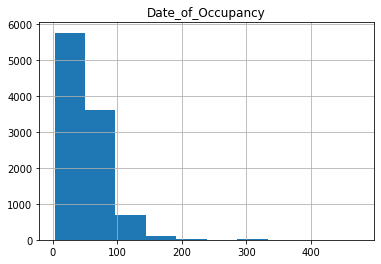

In [0]:
data.hist(column='Date_of_Occupancy')

In [0]:
# data.Date_of_Occupancy = data.Date_of_Occupancy.apply(lambda x:0 if x in range(0, 50) else 1 if x in range(51, 100) else 2 if x in range(101, 150) else 3)

In [0]:
data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim,sep
0,H14663,6,1.0,0,N,V,V,U,290.0,1,59,.,1053,0.0,train
1,H2037,4,1.0,0,V,N,O,R,490.0,1,169,4,1053,0.0,train
2,H3802,5,1.0,0,N,V,V,U,595.0,1,59,.,1053,0.0,train
3,H3834,6,1.0,0,V,V,V,U,2840.0,1,59,.,1053,0.0,train
4,H5053,5,1.0,0,V,N,O,R,680.0,1,219,3,1053,0.0,train


## Treating Outliers

In [0]:
data.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000,7160.000000
mean,5.353211,0.913672,0.281064,1808.658129,2.238049,53.341578,0.228212
std,1.380660,0.233806,0.449540,2260.549783,0.961589,31.497442,0.419709
min,3.000000,0.000000,0.000000,1.000000,1.000000,3.000000,0.000000
25%,4.000000,1.000000,0.000000,510.000000,2.000000,39.000000,0.000000
50%,6.000000,1.000000,0.000000,1002.000000,2.000000,49.000000,0.000000
75%,7.000000,1.000000,1.000000,2167.000000,3.000000,59.000000,0.000000
max,7.000000,1.000000,1.000000,30745.000000,4.000000,474.000000,1.000000


In [0]:
data['YearOfObservation'].value_counts()

7    2724
6    2587
5    1930
4    1554
3    1434
Name: YearOfObservation, dtype: int64

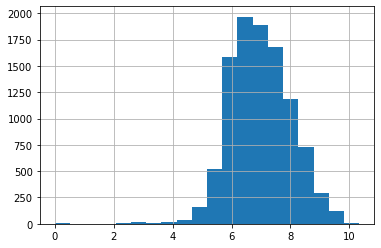

In [0]:
data['Building Dimension'] = np.log(data['Building Dimension']) 
data['Building Dimension'].hist(bins=20) 

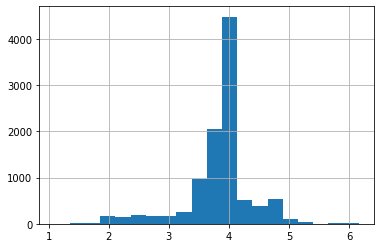

In [0]:
data['Date_of_Occupancy'] = np.log(data['Date_of_Occupancy']) 
data['Date_of_Occupancy'].hist(bins=20) 

# Feature Engineering

In [0]:
data.columns

Index(['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy', 'Geo_Code',
       'Claim', 'sep'],
      dtype='object')

In [0]:
data.drop(['NumberOfWindows', 'Garden'], axis=1, inplace=True) 

## One-Hot Encoding

In [0]:
# identifying categorical features
categorical_features = [x for x in data.columns if data[x].dtype == 'object']
print(categorical_features)

['Customer Id', 'Building_Painted', 'Building_Fenced', 'Settlement', 'Geo_Code', 'sep']


In [0]:
#Import library:
from sklearn.preprocessing import LabelEncoder
#New variable
var_mod = ['Geo_Code']
le = LabelEncoder()
for i in var_mod:
    # data[i] = le.fit_transform(data[i])
    data[i] = le.fit_transform(data[i].astype(str))

## Get dummy variables

In [0]:
# identifying categorical features
categorical_features = [x for x in data.columns if data[x].dtype == 'object']
# get dummy variable
data = pd.get_dummies(data, columns = [x for x in categorical_features if x not in ['sep', 'Customer Id', 'Geo_Code']])

In [0]:
data.columns

Index(['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy', 'Geo_Code',
       'Claim', 'sep', 'Building_Painted_N', 'Building_Painted_V',
       'Building_Fenced_N', 'Building_Fenced_V', 'Settlement_R',
       'Settlement_U'],
      dtype='object')

In [0]:
data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Geo_Code,Claim,sep,Building_Painted_N,Building_Painted_V,Building_Fenced_N,Building_Fenced_V,Settlement_R,Settlement_U
0,H14663,6,1.0,0,5.669881,1,4.077537,7,0.0,train,1,0,0,1,0,1
1,H2037,4,1.0,0,6.194405,1,5.129899,7,0.0,train,0,1,1,0,1,0
2,H3802,5,1.0,0,6.388561,1,4.077537,7,0.0,train,1,0,0,1,0,1
3,H3834,6,1.0,0,7.951559,1,4.077537,7,0.0,train,0,1,0,1,0,1
4,H5053,5,1.0,0,6.522093,1,5.389072,7,0.0,train,0,1,1,0,1,0


# Get train and test data

In [0]:
train = data[data.sep == 'train'].reset_index(drop=True)
test = data[data.sep == 'test'].reset_index(drop=True)
train.drop('sep', axis=1, inplace=True)
test.drop('sep', axis=1, inplace=True)
train['Claim'] = train['Claim'].astype('int64')
print(len(train), len(test))

7160 3069


## X, y split

In [0]:
train.Claim.value_counts()

0    5526
1    1634
Name: Claim, dtype: int64

In [0]:
# Get all the columns from the dataFrame
columns = train.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Claim", "Customer Id"]]

# Store the variable we'll be predicting on
target = "Claim"

X = train[columns]
y = train[target]

# Print shapes
print(X.shape)
print(y.shape)

(7160, 13)
(7160,)


## Model Preparation

In [0]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Models

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm as lgb

def get_model(X_train, X_test, y_train, y_test, model):

    scaler = MinMaxScaler()
    x_train_pre = scaler.fit_transform(X_train)
    x_test_pre = scaler.transform(X_test)
              
    # y_preprocessing = StandardScaler()
    # y_preprocessing.fit(y_train)
    y_train_pre = y_train
    y_test_pre = y_test

    if model == 'GBC':
        model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
        model.fit(x_train_pre,y_train_pre)
        y_prob = model.predict(x_test_pre)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_pre, y_prob)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print("ROC:", roc_auc)
        
    if model == 'SVC':
        model = SVC()
        model.fit(x_train_pre,y_train_pre) 
        y_prob = model.predict(x_test_pre)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_pre, y_prob)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print("ROC:", roc_auc)
        
    if model == 'RFC':
        model = RandomForestClassifier(n_estimators=200)
        model.fit(x_train_pre,y_train_pre)
        y_prob = model.predict(x_test_pre)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_pre, y_prob)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print("ROC:", roc_auc)
        
    if model == 'XGB':
        model = xgb.XGBClassifier(n_estimators=300)
        model.fit(x_train_pre,y_train_pre) 
        y_prob = model.predict(x_test_pre)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_pre, y_prob)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print("ROC:", roc_auc)

    if model == 'HGB':
      model = HistGradientBoostingClassifier(max_iter=100)
      model.fit(x_train_pre,y_train_pre) 
      y_prob = model.predict(x_test_pre)
      false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_pre, y_prob)
      roc_auc = auc(false_positive_rate, true_positive_rate)
      print("ROC:", roc_auc)
    
    if model == 'LGBM':
      model = lgb.LGBMClassifier(n_estimators=100, silent=True)
      model.fit(x_train_pre,y_train_pre, eval_set=[(x_test_pre,y_test_pre)], early_stopping_rounds=5, verbose=False) 
      y_prob = model.predict(x_test_pre)
      false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_pre, y_prob)
      roc_auc = auc(false_positive_rate, true_positive_rate)
      print("ROC:", roc_auc)

# Stack

In [0]:
# !pip install catboost

In [0]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

In [0]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=2016).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
#                y_holdout = y[test_idx]

                print ("Fit %s fold %d" % (str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
#                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
#                print("    cross_score: %.5f" % (cross_score.mean()))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=5, scoring='roc_auc')
        print("Stacker score: %.5f" % (results.mean()))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res


        
# LightGBM params
lgb_params = {}
lgb_params['learning_rate'] = 0.02
lgb_params['n_estimators'] = 150
lgb_params['max_bin'] = 10
lgb_params['subsample'] = 0.8
lgb_params['subsample_freq'] = 10
lgb_params['colsample_bytree'] = 0.8   
lgb_params['min_child_samples'] = 500
lgb_params['seed'] = 99


lgb_params2 = {}
lgb_params2['n_estimators'] = 200
lgb_params2['learning_rate'] = 0.05
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 99


lgb_params3 = {}
lgb_params3['n_estimators'] = 300
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 99

lgb_params4 = {}
lgb_params4['n_estimators'] = 400
lgb_params4['learning_rate'] = 0.01
lgb_params4['colsample_bytree'] = 0.3   
lgb_params4['subsample'] = 0.7
lgb_params4['subsample_freq'] = 2
lgb_params4['num_leaves'] = 16
lgb_params4['seed'] = 99


# RandomForest params
rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 6
rf_params['min_samples_split'] = 70
rf_params['min_samples_leaf'] = 30


# ExtraTrees params
et_params = {}
et_params['n_estimators'] = 155
et_params['max_features'] = 0.3
et_params['max_depth'] = 6
et_params['min_samples_split'] = 40
et_params['min_samples_leaf'] = 18


# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 300
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10


#CatBoost params
cat_params = {}
cat_params['iterations'] = 1000
cat_params['depth'] = 8
cat_params['rsm'] = 0.95
cat_params['learning_rate'] = 0.01
cat_params['l2_leaf_reg'] = 3.5  
cat_params['border_count'] = 8



lgb_model = LGBMClassifier(**lgb_params)

lgb_model2 = LGBMClassifier(**lgb_params2)

lgb_model3 = LGBMClassifier(**lgb_params3)

lgb_model4 = LGBMClassifier(**lgb_params4)

rf_model = RandomForestClassifier(**rf_params)

et_model = ExtraTreesClassifier(**et_params)
        
xgb_model = XGBClassifier(**xgb_params)

cat_model = CatBoostClassifier(**cat_params)


gb_model = GradientBoostingClassifier(max_depth=5)

ada_model = AdaBoostClassifier()

log_model = LogisticRegression()

hgb_model = HistGradientBoostingClassifier(max_iter=100)


        
stack = Ensemble(n_splits=5,
        stacker = log_model,
        base_models = (lgb_model,lgb_model2,lgb_model3, lgb_model4, cat_model, ada_model, log_model))        
        
y_pred = stack.fit_predict(X, y, test[columns])        

Fit LGBMClassifier fold 1
Fit LGBMClassifier fold 2
Fit LGBMClassifier fold 3
Fit LGBMClassifier fold 4
Fit LGBMClassifier fold 5
Fit LGBMClassifier fold 1
Fit LGBMClassifier fold 2
Fit LGBMClassifier fold 3
Fit LGBMClassifier fold 4
Fit LGBMClassifier fold 5
Fit LGBMClassifier fold 1
Fit LGBMClassifier fold 2
Fit LGBMClassifier fold 3
Fit LGBMClassifier fold 4
Fit LGBMClassifier fold 5
Fit LGBMClassifier fold 1
Fit LGBMClassifier fold 2
Fit LGBMClassifier fold 3
Fit LGBMClassifier fold 4
Fit LGBMClassifier fold 5
Fit <catboost.core.CatBoostClassifier object at 0x7fc5d564ff28> fold 1
0:	learn: 0.6883108	total: 4.23ms	remaining: 4.23s
1:	learn: 0.6837774	total: 8.22ms	remaining: 4.1s
2:	learn: 0.6794813	total: 11.4ms	remaining: 3.78s
3:	learn: 0.6751163	total: 15.4ms	remaining: 3.84s
4:	learn: 0.6707986	total: 19.3ms	remaining: 3.84s
5:	learn: 0.6665496	total: 23.3ms	remaining: 3.85s
6:	learn: 0.6624015	total: 27.2ms	remaining: 3.86s
7:	learn: 0.6583766	total: 31.1ms	remaining: 3.85s
8:

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Stacker score: 0.72258


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [0]:
0.72361  

0.72361

In [0]:
sub = pd.DataFrame()
sub['id'] = test['Customer Id']
sub['target'] = y_pred
sub.to_csv('stacked_2.csv', index=False)

## Test

In [0]:
#run the models
for i in ['GBC','SVC','RFC','XGB', 'HGB', 'LGBM']:
    print(f"{i} score:")
    get_model(X_train, X_test, y_train, y_test, model = i)

GBC score:
ROC: 0.5736691609789506
SVC score:


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


ROC: 0.5
RFC score:
ROC: 0.605824278934414
XGB score:
ROC: 0.5928753243574354
HGB score:
ROC: 0.5982183365949362
LGBM score:
ROC: 0.585263818955702


# Final Model

In [0]:
# xgboost
clf = lgb.LGBMClassifier(n_estimators=100, silent=True)

# from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# from sklearn.ensemble import HistGradientBoostingClassifier
# clf1 = HistGradientBoostingClassifier(max_iter=500)

%time clf.fit(X_train, y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=5, verbose=False) 

CPU times: user 81.4 ms, sys: 0 ns, total: 81.4 ms
Wall time: 83 ms


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
y_pred = clf.predict(X_test)

In [0]:
# Run classification metrics
print('accuracy')
print(accuracy_score(y_test, y_pred))
print('f1 score')
print(f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

accuracy
0.7914338919925512
f1 score
0.7478564101203269
              precision    recall  f1-score   support

           0       0.80      0.96      0.88      1661
           1       0.62      0.20      0.31       487

    accuracy                           0.79      2148
   macro avg       0.71      0.58      0.59      2148
weighted avg       0.76      0.79      0.75      2148



In [0]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,1601,60
1,388,99


# Submission

In [0]:
sub_test = test[columns]

# Print shapes
print(sub_test.shape)

(3069, 11)


In [0]:
sub_pred = clf.predict(sub_test)
sub_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [0]:
test["Claim"] = sub_pred
test["Claim"] = test["Claim"].astype('int64')

In [0]:
test.Claim.value_counts()

0    2845
1     224
Name: Claim, dtype: int64

In [0]:
submission = test[["Customer Id", "Claim"]]
submission.tail()

,Customer Id,Claim
3064,H11583,0
3065,H11720,0
3066,H11721,0
3067,H12408,0
3068,H9021,0


In [0]:
submission.to_csv('submission.csv',index=False)